# Notebook for generating FAQ with Hierarchcal Agglomerative Clustering

## Setup

In [1]:
import os
import json
import requests
from azure.storage.blob import BlobServiceClient, BlobClient, ContainerClient
import pandas as pd
from pyspark.sql.functions import col, explode, collect_list, struct, udf, concat, monotonically_increasing_id, to_json, when, from_json, concat_ws, current_timestamp, lit
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, TimestampType, ArrayType, FloatType
from bs4 import BeautifulSoup
from synapse.ml.featurize.text import PageSplitter
from abc import ABC, abstractmethod 
import openai
import numpy as np
import re
from pyspark.ml.feature import Tokenizer, StopWordsRemover, HashingTF, IDF
from pyspark.ml.clustering import KMeans
from pyspark.ml import Pipeline 
from nltk.corpus import stopwords 

import uuid 
from transformers import AutoTokenizer

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

from datetime import datetime, timedelta
import httpx

StatementMeta(, 74b7028d-71e0-4c82-9b60-67d2c99a5b3c, 5, Finished, Available, Finished)

2025-04-03 15:36:16.494322: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-03 15:36:18.581391: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Load data

In [2]:
# SAS URL of the blob with JSON file
sas_url = "https://aka.ms/funwithteams"

# Download the blob content using the SAS URL
response = requests.get(sas_url)
blob_content = response.content

# Parse the JSON content
try:
    json_content = json.loads(blob_content)
    print("JSON is valid.")
except json.JSONDecodeError as e:
    print(f"Invalid JSON: {e}")
    json_content = None

# Print the first 20 lines of the JSON content if valid
if json_content:
    json_str = json.dumps(json_content, indent=4)
    json_lines = json_str.split('\n')
    for line in json_lines[:20]:
        print(line)

StatementMeta(, 74b7028d-71e0-4c82-9b60-67d2c99a5b3c, 6, Finished, Available, Finished)

JSON is valid.
[
    {
        "Theme": "Chemistry",
        "Id": "messages_Chemistry_20250320_045328_df44f0a2",
        "Thread": {
            "parent": {
                "@odata.context": "https://graph.microsoft.com/v1.0/$metadata#teams('fbe2bf47-16c8-47cf-b4a5-4b9b187c508b')/channels('19%3A4a95f7d8db4c4e7fae857bcebe0623e6%40thread.tacv2')/messages",
                "@odata.count": 1,
                "@odata.nextLink": "https://graph.microsoft.com/v1.0/teams/fbe2bf47-16c8-47cf-b4a5-4b9b187c508b/channels/19:4a95f7d8db4c4e7fae857bcebe0623e6@thread.tacv2/messages?$skiptoken=%5b...%22%7D%7D%5d",
                "value": [
                    {
                        "id": "1698751205583",
                        "replyToId": null,
                        "etag": "1698751205583",
                        "messageType": "message",
                        "createdDateTime": "2023-11-05T14:30:05.583Z",
                        "lastModifiedDateTime": "2023-11-05T14:30:05.583Z",
           

## EDA

In [3]:
# Normalize the JSON data into a flat table
df = pd.json_normalize(json_content)

# Print the DataFrame
df.head(10)

StatementMeta(, 74b7028d-71e0-4c82-9b60-67d2c99a5b3c, 7, Finished, Available, Finished)

,Theme,Id,Thread.parent.@odata.context,Thread.parent.@odata.count,Thread.parent.@odata.nextLink,Thread.parent.value,Thread.children.@odata.context,Thread.children.@odata.count,Thread.children.value
0,Chemistry,messages_Chemistry_20250320_045328_df44f0a2,https://graph.microsoft.com/v1.0/$metadata#tea...,1.0,https://graph.microsoft.com/v1.0/teams/fbe2bf4...,"[{'id': '1698751205583', 'replyToId': None, 'e...",https://graph.microsoft.com/v1.0/$metadata#tea...,6,"[{'id': '1698751300458', 'replyToId': '1698751..."
1,Chemistry,messages_Chemistry_20250320_045456_0e872825,https://graph.microsoft.com/v1.0/$metadata#tea...,1.0,https://graph.microsoft.com/v1.0/teams/fbe2bf4...,"[{'id': '1616989510410', 'replyToId': None, 'e...",https://graph.microsoft.com/v1.0/$metadata#tea...,5,"[{'id': '1616989750101', 'replyToId': '1616989..."
2,Chemistry,messages_Chemistry_20250320_045526_8889036f,https://graph.microsoft.com/v1.0/$metadata#tea...,1.0,https://graph.microsoft.com/v1.0/teams/fbe2bf4...,"[{'id': '1616989510408', 'replyToId': None, 'e...",https://graph.microsoft.com/v1.0/$metadata#tea...,4,"[{'id': '1616989747416', 'replyToId': '1616989..."
3,Chemistry,messages_Chemistry_20250320_045814_d41a954a,https://graph.microsoft.com/v1.0/$metadata#tea...,1.0,https://graph.microsoft.com/v1.0/teams/team-id...,"[{'id': '1698657641023', 'replyToId': None, 'e...",https://graph.microsoft.com/v1.0/$metadata#tea...,3,"[{'id': '1698657685001', 'replyToId': '1698657..."
4,Chemistry,messages_Chemistry_20250320_050600_cb344deb,https://graph.microsoft.com/v1.0/$metadata#tea...,1.0,https://graph.microsoft.com/v1.0/teams/teamId:...,"[{'id': '1698791234567', 'replyToId': None, 'e...",https://graph.microsoft.com/v1.0/$metadata#tea...,3,"[{'id': '1698791267001', 'replyToId': '1698791..."
5,Chemistry,messages_Chemistry_20250320_050947_2c43f2ba,https://graph.microsoft.com/v1.0/$metadata#tea...,1.0,https://graph.microsoft.com/v1.0/teams/fbe2bf4...,"[{'id': '1617989510408', 'replyToId': None, 'e...",https://graph.microsoft.com/v1.0/$metadata#tea...,9,"[{'id': '1617989753412', 'replyToId': '1617989..."
6,Chemistry,messages_Chemistry_20250320_051407_e3396f52,https://graph.microsoft.com/v1.0/$metadata#tea...,1.0,https://graph.microsoft.com/v1.0/teams/abc307d...,"[{'id': '1695838725084', 'replyToId': None, 'e...",https://graph.microsoft.com/v1.0/$metadata#tea...,4,"[{'id': '1695838793245', 'replyToId': '1695838..."
7,Chemistry,messages_Chemistry_20250320_051537_e437647f,https://graph.microsoft.com/v1.0/$metadata#tea...,1.0,https://graph.microsoft.com/v1.0/teams/abc1234...,"[{'id': '1689750013579', 'replyToId': None, 'e...",https://graph.microsoft.com/v1.0/$metadata#tea...,6,"[{'id': '1689750089001', 'replyToId': '1689750..."
8,Chemistry,messages_Chemistry_20250320_053156_939895f9,https://graph.microsoft.com/v1.0/$metadata#tea...,1.0,https://graph.microsoft.com/v1.0/teams/fbe2bf4...,"[{'id': '1698265010248', 'replyToId': None, 'e...",https://graph.microsoft.com/v1.0/$metadata#tea...,5,"[{'id': '1698265067742', 'replyToId': '1698265..."
9,Chemistry,messages_Chemistry_20250320_053736_cf657902,https://graph.microsoft.com/v1.0/$metadata#tea...,1.0,https://graph.microsoft.com/v1.0/teams/3a94d7f...,"[{'id': '1698745610408', 'replyToId': None, 'e...",https://graph.microsoft.com/v1.0/$metadata#tea...,5,"[{'id': '1698745621845', 'replyToId': '1698745..."


## Extract conversational texts from Teams Json

In [4]:
# Function to extract 'body->content' from JSON string
def extract_body_content(json_str):
    try:
        #json_data = json.loads(str(json_str))
        #return json_data['body']['content']
        return json_str[0]["body"]["content"]
    except (json.JSONDecodeError, KeyError) as e:
        print(e)
        return None

# Apply the function to create a new column 'parent_post_text'
df['parent_post_text'] = df['Thread.parent.value'].apply(extract_body_content)

df.head(30)

StatementMeta(, 74b7028d-71e0-4c82-9b60-67d2c99a5b3c, 8, Finished, Available, Finished)

,Theme,Id,Thread.parent.@odata.context,Thread.parent.@odata.count,Thread.parent.@odata.nextLink,Thread.parent.value,Thread.children.@odata.context,Thread.children.@odata.count,Thread.children.value,parent_post_text
0,Chemistry,messages_Chemistry_20250320_045328_df44f0a2,https://graph.microsoft.com/v1.0/$metadata#tea...,1.0,https://graph.microsoft.com/v1.0/teams/fbe2bf4...,"[{'id': '1698751205583', 'replyToId': None, 'e...",https://graph.microsoft.com/v1.0/$metadata#tea...,6,"[{'id': '1698751300458', 'replyToId': '1698751...","Hey team, I wanted to discuss the relationship..."
1,Chemistry,messages_Chemistry_20250320_045456_0e872825,https://graph.microsoft.com/v1.0/$metadata#tea...,1.0,https://graph.microsoft.com/v1.0/teams/fbe2bf4...,"[{'id': '1616989510410', 'replyToId': None, 'e...",https://graph.microsoft.com/v1.0/$metadata#tea...,5,"[{'id': '1616989750101', 'replyToId': '1616989...","Hi Team, can we discuss the influence of diffe..."
2,Chemistry,messages_Chemistry_20250320_045526_8889036f,https://graph.microsoft.com/v1.0/$metadata#tea...,1.0,https://graph.microsoft.com/v1.0/teams/fbe2bf4...,"[{'id': '1616989510408', 'replyToId': None, 'e...",https://graph.microsoft.com/v1.0/$metadata#tea...,4,"[{'id': '1616989747416', 'replyToId': '1616989...",Hi team! Excited to dive into intermolecular f...
3,Chemistry,messages_Chemistry_20250320_045814_d41a954a,https://graph.microsoft.com/v1.0/$metadata#tea...,1.0,https://graph.microsoft.com/v1.0/teams/team-id...,"[{'id': '1698657641023', 'replyToId': None, 'e...",https://graph.microsoft.com/v1.0/$metadata#tea...,3,"[{'id': '1698657685001', 'replyToId': '1698657...",Can someone explain how intermolecular forces ...
4,Chemistry,messages_Chemistry_20250320_050600_cb344deb,https://graph.microsoft.com/v1.0/$metadata#tea...,1.0,https://graph.microsoft.com/v1.0/teams/teamId:...,"[{'id': '1698791234567', 'replyToId': None, 'e...",https://graph.microsoft.com/v1.0/$metadata#tea...,3,"[{'id': '1698791267001', 'replyToId': '1698791...","Hey team, let's discuss how water's unique pro..."
5,Chemistry,messages_Chemistry_20250320_050947_2c43f2ba,https://graph.microsoft.com/v1.0/$metadata#tea...,1.0,https://graph.microsoft.com/v1.0/teams/fbe2bf4...,"[{'id': '1617989510408', 'replyToId': None, 'e...",https://graph.microsoft.com/v1.0/$metadata#tea...,9,"[{'id': '1617989753412', 'replyToId': '1617989...",Catalysts play a critical role in lowering the...
6,Chemistry,messages_Chemistry_20250320_051407_e3396f52,https://graph.microsoft.com/v1.0/$metadata#tea...,1.0,https://graph.microsoft.com/v1.0/teams/abc307d...,"[{'id': '1695838725084', 'replyToId': None, 'e...",https://graph.microsoft.com/v1.0/$metadata#tea...,4,"[{'id': '1695838793245', 'replyToId': '1695838...","Hi Team, could someone explain how changes in ..."
7,Chemistry,messages_Chemistry_20250320_051537_e437647f,https://graph.microsoft.com/v1.0/$metadata#tea...,1.0,https://graph.microsoft.com/v1.0/teams/abc1234...,"[{'id': '1689750013579', 'replyToId': None, 'e...",https://graph.microsoft.com/v1.0/$metadata#tea...,6,"[{'id': '1689750089001', 'replyToId': '1689750...","Hey team, let's talk about how electron config..."
8,Chemistry,messages_Chemistry_20250320_053156_939895f9,https://graph.microsoft.com/v1.0/$metadata#tea...,1.0,https://graph.microsoft.com/v1.0/teams/fbe2bf4...,"[{'id': '1698265010248', 'replyToId': None, 'e...",https://graph.microsoft.com/v1.0/$metadata#tea...,5,"[{'id': '1698265067742', 'replyToId': '1698265...","Hey team, can we dive into how intermolecular ..."
9,Chemistry,messages_Chemistry_20250320_053736_cf657902,https://graph.microsoft.com/v1.0/$metadata#tea...,1.0,https://graph.microsoft.com/v1.0/teams/3a94d7f...,"[{'id': '1698745610408', 'replyToId': None, 'e...",https://graph.microsoft.com/v1.0/$metadata#tea...,5,"[{'id': '1698745621845', 'replyToId': '1698745...","Hi team, can we discuss how intermolecular for..."


## Example of a message that contains a tag of a person's name

In [5]:
# Display full content of parent_post_text in row with id = messages_Chemistry_20250320_055839_07f3eb8e
full_content = df.loc[df['Id'] == 'messages_Chemistry_20250320_055839_07f3eb8e', 'parent_post_text'].values
print(full_content)


StatementMeta(, 74b7028d-71e0-4c82-9b60-67d2c99a5b3c, 9, Finished, Available, Finished)

['<at id="0">Paul Hinton</at> <at id="1">Taylor Greene</at> Can we discuss how the principles of chemical bonding relate to material properties and technologies?']


## Segment parent posts into refined questions with GPT

In [6]:
#Define the function to segment post into questions
def segment_post_into_questions(parent_post_text):
    prompt = """
    You are given a message thread of someone addressing a team with one or more questions. Take it, remove individual names and other "fluff" and 
    break it down into concise self-contained questions, presented in json form of the following structure: 
    [{"question": "How to synthesize a protein with specific properties?"}].
    If the message contains no questions, return empty JSon array, without comments.
    """
    messages = [
        {
            "role": "system",
            "content": prompt
        }
    ]

    content = "Message: "
    if parent_post_text is not None:
        content += parent_post_text + "\n\n"

    messages.append(
        {
            "role": "user",
            "content": content,
        },
    )

    
    attempts = 0
    result = ''
    
    print(f"start to work on input: {parent_post_text}")
    while attempts < 10 and result == '':
        try:
            attempts+=1 

            response = openai.ChatCompletion.create(
                #deployment_id='gpt-35-turbo-0125', # see the note in the cell below for an alternative deployment_id.
                deployment_id="gpt-4-32k",
                messages= messages,
                temperature=0,
            ) 

            result = response.choices[0].message.content
            #print(result)
        except Exception as e:
            print(e)
            print(f"sleeping, attempt {attempts}")
            import time
            time.sleep(attempts*19)

    return result if result !='' else 'Failure'

StatementMeta(, 74b7028d-71e0-4c82-9b60-67d2c99a5b3c, 10, Finished, Available, Finished)

Test the function on a post that is a statement, without any embedded questions

In [7]:
segment_post_into_questions("'Catalysts play a critical role in lowering the activation energy of a chemical reaction, allowing it to proceed more quickly and efficiently without being consumed in the process. In industrial applications like the Haber process for ammonia production, iron-based catalysts are used to facilitate the reaction between nitrogen and hydrogen under optimized temperature and pressure conditions.'")

StatementMeta(, 74b7028d-71e0-4c82-9b60-67d2c99a5b3c, 11, Finished, Available, Finished)

start to work on input: 'Catalysts play a critical role in lowering the activation energy of a chemical reaction, allowing it to proceed more quickly and efficiently without being consumed in the process. In industrial applications like the Haber process for ammonia production, iron-based catalysts are used to facilitate the reaction between nitrogen and hydrogen under optimized temperature and pressure conditions.'


'[]'

Test the function on a "normal" type of post, with one question

In [8]:
segment_post_into_questions("Hey team, let's discuss how water's unique properties (like high specific heat, surface tension, and being a universal solvent) arise from its molecular structure and hydrogen bonding. <at id=\"0\">Sam Carter</at>, <at id=\"1\">Kim Lee</at>, what are your thoughts?")

StatementMeta(, 74b7028d-71e0-4c82-9b60-67d2c99a5b3c, 12, Finished, Available, Finished)

start to work on input: Hey team, let's discuss how water's unique properties (like high specific heat, surface tension, and being a universal solvent) arise from its molecular structure and hydrogen bonding. <at id="0">Sam Carter</at>, <at id="1">Kim Lee</at>, what are your thoughts?


'[{"question": "How do water\'s unique properties arise from its molecular structure and hydrogen bonding?"}]'

Apply the function to our dataset of ~1k conversations

In [9]:
#df_segmented = df.head(30)
df_segmented = df
df_segmented['questions'] = df_segmented['parent_post_text'].apply(segment_post_into_questions)
df_segmented

StatementMeta(, 74b7028d-71e0-4c82-9b60-67d2c99a5b3c, 13, Submitted, Running, Running)

start to work on input: Hey team, I wanted to discuss the relationship between intermolecular forces and physical properties like boiling point, melting point, and solubility. How do these forces influence these properties? Thoughts?
start to work on input: Hi Team, can we discuss the influence of different types of chemical bonds (ionic, covalent, metallic) on the physical properties of compounds like melting point, conductivity, and hardness?
start to work on input: Hi team! Excited to dive into intermolecular forces! <at id="0">Evelyn Moore</at>, <at id="1">Kai Johnson</at> - thoughts?
start to work on input: Can someone explain how intermolecular forces influence physical properties like boiling point and solubility?
start to work on input: Hey team, let's discuss how water's unique properties (like high specific heat, surface tension, and being a universal solvent) arise from its molecular structure and hydrogen bonding. <at id="0">Sam Carter</at>, <at id="1">Kim Lee</at>, what ar

,Theme,Id,Thread.parent.@odata.context,Thread.parent.@odata.count,Thread.parent.@odata.nextLink,Thread.parent.value,Thread.children.@odata.context,Thread.children.@odata.count,Thread.children.value,parent_post_text,questions
0,Chemistry,messages_Chemistry_20250320_045328_df44f0a2,https://graph.microsoft.com/v1.0/$metadata#tea...,1.0,https://graph.microsoft.com/v1.0/teams/fbe2bf4...,"[{'id': '1698751205583', 'replyToId': None, 'e...",https://graph.microsoft.com/v1.0/$metadata#tea...,6,"[{'id': '1698751300458', 'replyToId': '1698751...","Hey team, I wanted to discuss the relationship...","[{""question"": ""How do intermolecular forces in..."
1,Chemistry,messages_Chemistry_20250320_045456_0e872825,https://graph.microsoft.com/v1.0/$metadata#tea...,1.0,https://graph.microsoft.com/v1.0/teams/fbe2bf4...,"[{'id': '1616989510410', 'replyToId': None, 'e...",https://graph.microsoft.com/v1.0/$metadata#tea...,5,"[{'id': '1616989750101', 'replyToId': '1616989...","Hi Team, can we discuss the influence of diffe...","[{""question"": ""Can we discuss the influence of..."
2,Chemistry,messages_Chemistry_20250320_045526_8889036f,https://graph.microsoft.com/v1.0/$metadata#tea...,1.0,https://graph.microsoft.com/v1.0/teams/fbe2bf4...,"[{'id': '1616989510408', 'replyToId': None, 'e...",https://graph.microsoft.com/v1.0/$metadata#tea...,4,"[{'id': '1616989747416', 'replyToId': '1616989...",Hi team! Excited to dive into intermolecular f...,[]
3,Chemistry,messages_Chemistry_20250320_045814_d41a954a,https://graph.microsoft.com/v1.0/$metadata#tea...,1.0,https://graph.microsoft.com/v1.0/teams/team-id...,"[{'id': '1698657641023', 'replyToId': None, 'e...",https://graph.microsoft.com/v1.0/$metadata#tea...,3,"[{'id': '1698657685001', 'replyToId': '1698657...",Can someone explain how intermolecular forces ...,"[{""question"": ""Can someone explain how intermo..."
4,Chemistry,messages_Chemistry_20250320_050600_cb344deb,https://graph.microsoft.com/v1.0/$metadata#tea...,1.0,https://graph.microsoft.com/v1.0/teams/teamId:...,"[{'id': '1698791234567', 'replyToId': None, 'e...",https://graph.microsoft.com/v1.0/$metadata#tea...,3,"[{'id': '1698791267001', 'replyToId': '1698791...","Hey team, let's discuss how water's unique pro...","[{""question"": ""How do water's unique propertie..."
...,...,...,...,...,...,...,...,...,...,...,...
981,Watercolor,messages_Watercolor_20250320_172415_265bbadf,https://graph.microsoft.com/v1.0/$metadata#tea...,1.0,https://graph.microsoft.com/v1.0/teams/dc29bf1...,"[{'id': '3516983319408', 'replyToId': None, 'e...",https://graph.microsoft.com/v1.0/$metadata#tea...,3,"[{'id': '3516984359204', 'replyToId': '3516983...","Hey <at id=""0"">Daniel Lee</at>, <at id=""1"">Ale...","[{""question"": ""How does watercolor transparenc..."
982,Watercolor,messages_Watercolor_20250320_172534_7ba2cdcd,https://graph.microsoft.com/v1.0/$metadata#tea...,1.0,https://graph.microsoft.com/v1.0/teams/abc1234...,"[{'id': '1692314895123', 'replyToId': None, 'e...",https://graph.microsoft.com/v1.0/$metadata#tea...,3,"[{'id': '1692314984011', 'replyToId': '1692314...",Hi team! Let's dive into the techniques and ma...,[]
983,Watercolor,messages_Watercolor_20250320_172903_148217f2,https://graph.microsoft.com/v1.0/$metadata#tea...,1.0,https://graph.microsoft.com/v1.0/teams/a8dc45f...,"[{'id': '1636123456789', 'replyToId': None, 'e...",https://graph.microsoft.com/v1.0/$metadata#tea...,5,"[{'id': '1636125678912', 'replyToId': '1636123...",Hey team! I stumbled across a question that se...,"[\n {""question"": ""How does the transparency o..."
984,Watercolor,messages_Watercolor_20250320_174413_ba2a3d5a,https://graph.microsoft.com/v1.0/$metadata#tea...,1.0,https://graph.microsoft.com/v1.0/teams/a3b7df4...,"[{'id': '1693128408450', 'replyToId': None, 'e...",https://graph.microsoft.com/v1.0/$metadata#tea...,3,"[{'id': '1693128583100', 'replyToId': '1693128...",Can we brainstorm ideas on how factors like pa...,"[{""question"": ""Can we brainstorm ideas on how ..."


Sample result:

In [10]:
# Display full content of parent_post_text in row with id = messages_Chemistry_20250320_055839_07f3eb8e
questions = df_segmented.loc[df_segmented['Id'] == 'messages_Chemistry_20250320_053736_cf657902', 'questions'].values
print(questions)

StatementMeta(, , -1, Waiting, , Waiting)

['[{"question": "How do intermolecular forces, such as hydrogen bonding, dipole-dipole interactions, and London dispersion forces, influence physical properties like boiling point, melting point, and solubility?"}]']


## Expand to have an individual row for each question

In [11]:
# Function to expand questions into multiple rows
def expand_questions(value):
    try:
        questions_json = json.loads(value)
        return questions_json
    except json.JSONDecodeError:
        return []
 
df_segmented['questions_json'] = df_segmented['questions'].apply(expand_questions)
expanded_df = df_segmented.explode('questions_json').reset_index(drop=True)
expanded_df.head(20)

StatementMeta(, , -1, Waiting, , Waiting)

,Theme,Id,Thread.parent.@odata.context,Thread.parent.@odata.count,Thread.parent.@odata.nextLink,Thread.parent.value,Thread.children.@odata.context,Thread.children.@odata.count,Thread.children.value,parent_post_text,questions,questions_json
0,Chemistry,messages_Chemistry_20250320_045328_df44f0a2,https://graph.microsoft.com/v1.0/$metadata#tea...,1.0,https://graph.microsoft.com/v1.0/teams/fbe2bf4...,"[{'id': '1698751205583', 'replyToId': None, 'e...",https://graph.microsoft.com/v1.0/$metadata#tea...,6,"[{'id': '1698751300458', 'replyToId': '1698751...","Hey team, I wanted to discuss the relationship...","[{""question"": ""How do intermolecular forces in...",{'question': 'How do intermolecular forces inf...
1,Chemistry,messages_Chemistry_20250320_045456_0e872825,https://graph.microsoft.com/v1.0/$metadata#tea...,1.0,https://graph.microsoft.com/v1.0/teams/fbe2bf4...,"[{'id': '1616989510410', 'replyToId': None, 'e...",https://graph.microsoft.com/v1.0/$metadata#tea...,5,"[{'id': '1616989750101', 'replyToId': '1616989...","Hi Team, can we discuss the influence of diffe...","[{""question"": ""Can we discuss the influence of...",{'question': 'Can we discuss the influence of ...
2,Chemistry,messages_Chemistry_20250320_045526_8889036f,https://graph.microsoft.com/v1.0/$metadata#tea...,1.0,https://graph.microsoft.com/v1.0/teams/fbe2bf4...,"[{'id': '1616989510408', 'replyToId': None, 'e...",https://graph.microsoft.com/v1.0/$metadata#tea...,4,"[{'id': '1616989747416', 'replyToId': '1616989...",Hi team! Excited to dive into intermolecular f...,[],NaN
3,Chemistry,messages_Chemistry_20250320_045814_d41a954a,https://graph.microsoft.com/v1.0/$metadata#tea...,1.0,https://graph.microsoft.com/v1.0/teams/team-id...,"[{'id': '1698657641023', 'replyToId': None, 'e...",https://graph.microsoft.com/v1.0/$metadata#tea...,3,"[{'id': '1698657685001', 'replyToId': '1698657...",Can someone explain how intermolecular forces ...,"[{""question"": ""Can someone explain how intermo...",{'question': 'Can someone explain how intermol...
4,Chemistry,messages_Chemistry_20250320_050600_cb344deb,https://graph.microsoft.com/v1.0/$metadata#tea...,1.0,https://graph.microsoft.com/v1.0/teams/teamId:...,"[{'id': '1698791234567', 'replyToId': None, 'e...",https://graph.microsoft.com/v1.0/$metadata#tea...,3,"[{'id': '1698791267001', 'replyToId': '1698791...","Hey team, let's discuss how water's unique pro...","[{""question"": ""How do water's unique propertie...",{'question': 'How do water's unique properties...
5,Chemistry,messages_Chemistry_20250320_050947_2c43f2ba,https://graph.microsoft.com/v1.0/$metadata#tea...,1.0,https://graph.microsoft.com/v1.0/teams/fbe2bf4...,"[{'id': '1617989510408', 'replyToId': None, 'e...",https://graph.microsoft.com/v1.0/$metadata#tea...,9,"[{'id': '1617989753412', 'replyToId': '1617989...",Catalysts play a critical role in lowering the...,[],NaN
6,Chemistry,messages_Chemistry_20250320_051407_e3396f52,https://graph.microsoft.com/v1.0/$metadata#tea...,1.0,https://graph.microsoft.com/v1.0/teams/abc307d...,"[{'id': '1695838725084', 'replyToId': None, 'e...",https://graph.microsoft.com/v1.0/$metadata#tea...,4,"[{'id': '1695838793245', 'replyToId': '1695838...","Hi Team, could someone explain how changes in ...","[{""question"": ""How do changes in temperature, ...","{'question': 'How do changes in temperature, p..."
7,Chemistry,messages_Chemistry_20250320_051407_e3396f52,https://graph.microsoft.com/v1.0/$metadata#tea...,1.0,https://graph.microsoft.com/v1.0/teams/abc307d...,"[{'id': '1695838725084', 'replyToId': None, 'e...",https://graph.microsoft.com/v1.0/$metadata#tea...,4,"[{'id': '1695838793245', 'replyToId': '1695838...","Hi Team, could someone explain how changes in ...","[{""question"": ""How do changes in temperature, ...",{'question': 'Can you provide an example to cl...
8,Chemistry,messages_Chemistry_20250320_051537_e437647f,https://graph.microsoft.com/v1.0/$metadata#tea...,1.0,https://graph.microsoft.com/v1.0/teams/abc1234...,"[{'id': '168975

In [12]:
expanded_df.shape

StatementMeta(, , -1, Waiting, , Waiting)

(1751, 12)

## Clean rows that have no questions

In [13]:
# Filter the dataframe to non-empty values of questions_json
filtered_df = expanded_df[expanded_df['questions_json'].notna()]
filtered_df

StatementMeta(, , -1, Waiting, , Waiting)

,Theme,Id,Thread.parent.@odata.context,Thread.parent.@odata.count,Thread.parent.@odata.nextLink,Thread.parent.value,Thread.children.@odata.context,Thread.children.@odata.count,Thread.children.value,parent_post_text,questions,questions_json
0,Chemistry,messages_Chemistry_20250320_045328_df44f0a2,https://graph.microsoft.com/v1.0/$metadata#tea...,1.0,https://graph.microsoft.com/v1.0/teams/fbe2bf4...,"[{'id': '1698751205583', 'replyToId': None, 'e...",https://graph.microsoft.com/v1.0/$metadata#tea...,6,"[{'id': '1698751300458', 'replyToId': '1698751...","Hey team, I wanted to discuss the relationship...","[{""question"": ""How do intermolecular forces in...",{'question': 'How do intermolecular forces inf...
1,Chemistry,messages_Chemistry_20250320_045456_0e872825,https://graph.microsoft.com/v1.0/$metadata#tea...,1.0,https://graph.microsoft.com/v1.0/teams/fbe2bf4...,"[{'id': '1616989510410', 'replyToId': None, 'e...",https://graph.microsoft.com/v1.0/$metadata#tea...,5,"[{'id': '1616989750101', 'replyToId': '1616989...","Hi Team, can we discuss the influence of diffe...","[{""question"": ""Can we discuss the influence of...",{'question': 'Can we discuss the influence of ...
3,Chemistry,messages_Chemistry_20250320_045814_d41a954a,https://graph.microsoft.com/v1.0/$metadata#tea...,1.0,https://graph.microsoft.com/v1.0/teams/team-id...,"[{'id': '1698657641023', 'replyToId': None, 'e...",https://graph.microsoft.com/v1.0/$metadata#tea...,3,"[{'id': '1698657685001', 'replyToId': '1698657...",Can someone explain how intermolecular forces ...,"[{""question"": ""Can someone explain how intermo...",{'question': 'Can someone explain how intermol...
4,Chemistry,messages_Chemistry_20250320_050600_cb344deb,https://graph.microsoft.com/v1.0/$metadata#tea...,1.0,https://graph.microsoft.com/v1.0/teams/teamId:...,"[{'id': '1698791234567', 'replyToId': None, 'e...",https://graph.microsoft.com/v1.0/$metadata#tea...,3,"[{'id': '1698791267001', 'replyToId': '1698791...","Hey team, let's discuss how water's unique pro...","[{""question"": ""How do water's unique propertie...",{'question': 'How do water's unique properties...
6,Chemistry,messages_Chemistry_20250320_051407_e3396f52,https://graph.microsoft.com/v1.0/$metadata#tea...,1.0,https://graph.microsoft.com/v1.0/teams/abc307d...,"[{'id': '1695838725084', 'replyToId': None, 'e...",https://graph.microsoft.com/v1.0/$metadata#tea...,4,"[{'id': '1695838793245', 'replyToId': '1695838...","Hi Team, could someone explain how changes in ...","[{""question"": ""How do changes in temperature, ...","{'question': 'How do changes in temperature, p..."
...,...,...,...,...,...,...,...,...,...,...,...,...
1746,Watercolor,messages_Watercolor_20250320_172903_148217f2,https://graph.microsoft.com/v1.0/$metadata#tea...,1.0,https://graph.microsoft.com/v1.0/teams/a8dc45f...,"[{'id': '1636123456789', 'replyToId': None, 'e...",https://graph.microsoft.com/v1.0/$metadata#tea...,5,"[{'id': '1636125678912', 'replyToId': '1636123...",Hey team! I stumbled across a question that se...,"[\n {""question"": ""How does the transparency o...",{'question': 'How does the transparency of wat...
1747,Watercolor,messages_Watercolor_20250320_172903_148217f2,https://graph.microsoft.com/v1.0/$metadata#tea...,1.0,https://graph.microsoft.com/v1.0/teams/a8dc45f...,"[{'id': '1636123456789', 'replyToId': None, 'e...",https://graph.microsoft.com/v1.0/$metadata#tea...,5,"[{'id': '1636125678912', 'replyToId': '1636123...",Hey team! I stumbled across a question that se...,"[\n {""question"": ""How does the transparency o...",{'question': 'What role does paper texture pla...
1748,Watercolor,messages_Watercolor_20250320_174413_ba2a3d5a,https://graph.microsoft.com/v1.0/$metadata#tea...,1.0,https://graph.microsoft.com/v1.0/teams/a3b7df4...,"[{'id': '1693128408450', 'replyToId': None, 'e...",https://graph.microsoft.com/v1.0/$metadata#tea...,3,"[{'id': '1693128583100', 'replyToId': '1693128...",Can we brainstorm ideas on how factors like pa...,"[{""question"": ""Can

In [14]:
filtered_df.shape

StatementMeta(, , -1, Waiting, , Waiting)

(1645, 12)

In [15]:
# Display full content of parent_post_text in row with id = messages_Chemistry_20250320_055839_07f3eb8e
questions = filtered_df.loc[filtered_df['Id'] == 'messages_Chemistry_20250320_051407_e3396f52', 'questions_json'].values
print(questions, type(questions))

StatementMeta(, , -1, Waiting, , Waiting)

[{'question': "How do changes in temperature, pressure, and concentration affect equilibrium using Le Chatelier's Principle?"}
 {'question': "Can you provide an example to clarify how changes in temperature, pressure, and concentration affect equilibrium using Le Chatelier's Principle?"}] <class 'numpy.ndarray'>


## Crack JSON open to get the refined questions out

In [16]:
def expand_questions(value): 
    try: 
        return value['question']
    except json.JSONDecodeError:
        return ''

# Make a column 'question_refined' with value of 'question'
filtered_df['question_refined'] = filtered_df['questions_json'].apply(expand_questions)
filtered_df

StatementMeta(, , -1, Waiting, , Waiting)

/tmp/ipykernel_9393/820583064.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['question_refined'] = filtered_df['questions_json'].apply(expand_questions)


,Theme,Id,Thread.parent.@odata.context,Thread.parent.@odata.count,Thread.parent.@odata.nextLink,Thread.parent.value,Thread.children.@odata.context,Thread.children.@odata.count,Thread.children.value,parent_post_text,questions,questions_json,question_refined
0,Chemistry,messages_Chemistry_20250320_045328_df44f0a2,https://graph.microsoft.com/v1.0/$metadata#tea...,1.0,https://graph.microsoft.com/v1.0/teams/fbe2bf4...,"[{'id': '1698751205583', 'replyToId': None, 'e...",https://graph.microsoft.com/v1.0/$metadata#tea...,6,"[{'id': '1698751300458', 'replyToId': '1698751...","Hey team, I wanted to discuss the relationship...","[{""question"": ""How do intermolecular forces in...",{'question': 'How do intermolecular forces inf...,How do intermolecular forces influence physica...
1,Chemistry,messages_Chemistry_20250320_045456_0e872825,https://graph.microsoft.com/v1.0/$metadata#tea...,1.0,https://graph.microsoft.com/v1.0/teams/fbe2bf4...,"[{'id': '1616989510410', 'replyToId': None, 'e...",https://graph.microsoft.com/v1.0/$metadata#tea...,5,"[{'id': '1616989750101', 'replyToId': '1616989...","Hi Team, can we discuss the influence of diffe...","[{""question"": ""Can we discuss the influence of...",{'question': 'Can we discuss the influence of ...,Can we discuss the influence of different type...
3,Chemistry,messages_Chemistry_20250320_045814_d41a954a,https://graph.microsoft.com/v1.0/$metadata#tea...,1.0,https://graph.microsoft.com/v1.0/teams/team-id...,"[{'id': '1698657641023', 'replyToId': None, 'e...",https://graph.microsoft.com/v1.0/$metadata#tea...,3,"[{'id': '1698657685001', 'replyToId': '1698657...",Can someone explain how intermolecular forces ...,"[{""question"": ""Can someone explain how intermo...",{'question': 'Can someone explain how intermol...,Can someone explain how intermolecular forces ...
4,Chemistry,messages_Chemistry_20250320_050600_cb344deb,https://graph.microsoft.com/v1.0/$metadata#tea...,1.0,https://graph.microsoft.com/v1.0/teams/teamId:...,"[{'id': '1698791234567', 'replyToId': None, 'e...",https://graph.microsoft.com/v1.0/$metadata#tea...,3,"[{'id': '1698791267001', 'replyToId': '1698791...","Hey team, let's discuss how water's unique pro...","[{""question"": ""How do water's unique propertie...",{'question': 'How do water's unique properties...,How do water's unique properties arise from it...
6,Chemistry,messages_Chemistry_20250320_051407_e3396f52,https://graph.microsoft.com/v1.0/$metadata#tea...,1.0,https://graph.microsoft.com/v1.0/teams/abc307d...,"[{'id': '1695838725084', 'replyToId': None, 'e...",https://graph.microsoft.com/v1.0/$metadata#tea...,4,"[{'id': '1695838793245', 'replyToId': '1695838...","Hi Team, could someone explain how changes in ...","[{""question"": ""How do changes in temperature, ...","{'question': 'How do changes in temperature, p...","How do changes in temperature, pressure, and c..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1746,Watercolor,messages_Watercolor_20250320_172903_148217f2,https://graph.microsoft.com/v1.0/$metadata#tea...,1.0,https://graph.microsoft.com/v1.0/teams/a8dc45f...,"[{'id': '1636123456789', 'replyToId': None, 'e...",https://graph.microsoft.com/v1.0/$metadata#tea...,5,"[{'id': '1636125678912', 'replyToId': '1636123...",Hey team! I stumbled across a question that se...,"[\n {""question"": ""How does the transparency o...",{'question': 'How does the transparency of wat...,How does the transparency of watercolor paint ...
1747,Watercolor,messages_Watercolor_20250320_172903_148217f2,https://graph.microsoft.com/v1.0/$metadata#tea...,1.0,https://graph.microsoft.com/v1.0/teams/a8dc45f...,"[{'id': '1636123456789', 'replyToId': None, 'e...",https://graph.microsoft.com/v1.0/$metadata#tea...,5,"[{'id': '1636125678912', 'replyToId': '1636123...",Hey team! I stumbled across a question that se...,"[\n {""question"": ""How does the transparency o...",{'question': 'What role does paper texture pla...,What role does paper texture play in achieving...
1748,Watercolor,mess

In [17]:
filtered_df.shape

StatementMeta(, , -1, Waiting, , Waiting)

(1645, 13)

## Shuffle rows in the dataset - don't have to do it, but makes it more interesting!

In [18]:
shuffled_df = filtered_df.sample(frac=1).reset_index(drop=True)
shuffled_df

StatementMeta(, , -1, Waiting, , Waiting)

,Theme,Id,Thread.parent.@odata.context,Thread.parent.@odata.count,Thread.parent.@odata.nextLink,Thread.parent.value,Thread.children.@odata.context,Thread.children.@odata.count,Thread.children.value,parent_post_text,questions,questions_json,question_refined
0,Leadership,messages_Leadership_20250320_084547_22c33a5f,https://graph.microsoft.com/v1.0/$metadata#tea...,1.0,https://graph.microsoft.com/v1.0/teams/f6e9d84...,"[{'id': '1698745123048', 'replyToId': None, 'e...",https://graph.microsoft.com/v1.0/$metadata#tea...,3,"[{'id': '1698745187416', 'replyToId': '1698745...","Hi team, I wanted to discuss how effective lea...","[{""question"": ""How do effective leadership sty...",{'question': 'How do effective leadership styl...,How do effective leadership styles adapt to di...
1,Leadership,messages_Leadership_20250320_134807_884febda,https://graph.microsoft.com/v1.0/$metadata#tea...,1.0,https://graph.microsoft.com/v1.0/teams/12345/c...,"[{'id': '1738492810274', 'replyToId': None, 'e...",https://graph.microsoft.com/v1.0/$metadata#tea...,3,"[{'id': '1738492810765', 'replyToId': '1738492...",This is a great question! How can leaders bala...,"[{""question"": ""How can leaders balance inspira...",{'question': 'How can leaders balance inspirat...,"How can leaders balance inspiration, accountab..."
2,Hiking,messages_Hiking_20250320_085714_065302a9,https://graph.microsoft.com/v1.0/$metadata#tea...,1.0,https://graph.microsoft.com/v1.0/teams/hiking-...,"[{'id': '1696951043698', 'replyToId': None, 'e...",https://graph.microsoft.com/v1.0/$metadata#tea...,5,"[{'id': '1696951125698', 'replyToId': '1696951...","Hey team! <at id=""0"">Chris Lynn</at>, <at id=""...","[\n {""question"": ""What are your thoughts on t...",{'question': 'What are your thoughts on the es...,What are your thoughts on the essential items ...
3,Cooking,messages_Cooking_20250320_061541_67753d78,https://graph.microsoft.com/v1.0/$metadata#tea...,1.0,https://graph.microsoft.com/v1.0/teams/a739bc2...,"[{'id': '1697581045324', 'replyToId': None, 'e...",https://graph.microsoft.com/v1.0/$metadata#tea...,4,"[{'id': '1697581078902', 'replyToId': '1697581...",What are the foundational techniques in cookin...,"[{""question"": ""What are the foundational techn...",{'question': 'What are the foundational techni...,What are the foundational techniques in cooking?
4,Leadership,messages_Leadership_20250320_123221_061c7754,https://graph.microsoft.com/v1.0/$metadata#tea...,1.0,NaN,"[{'id': '1698765432109', 'replyToId': None, 'e...",https://graph.microsoft.com/v1.0/$metadata#tea...,5,"[{'id': '1698765453222', 'replyToId': '1698765...",How can a leader effectively balance the need ...,"[{""question"": ""How can a leader effectively ba...",{'question': 'How can a leader maintain a posi...,How can a leader maintain a positive and inclu...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1640,Education,messages_Education_20250320_173013_b153d4b3,https://graph.microsoft.com/v1.0/$metadata#tea...,1.0,https://graph.microsoft.com/v1.0/teams/abc123/...,"[{'id': '1698783207401', 'replyToId': None, 'e...",https://graph.microsoft.com/v1.0/$metadata#tea...,4,"[{'id': '1698783408587', 'replyToId': '1698783...",How can education systems adapt to ensure stud...,"[{""question"": ""How can education systems adapt...",{'question': 'How can education systems adapt ...,How can education systems adapt to ensure stud...
1641,Leadership,messages_Leadership_20250320_085601_2bab990b,https://graph.microsoft.com/v1.0/$metadata#tea...,1.0,NaN,"[{'id': '1698537610949', 'replyToId': None, 'e...",https://graph.microsoft.com/v1.0/$metadata#tea...,5,"[{'id': '1698537721234', 'replyToId': '1698537...","Hi team, let's discuss the qualities that defi...","[{""question"": ""What qualities define effective...",{'question': 'What qualities define effective ...,What qualities define effective leaders in tim...
1642,Watercolor,messages_Watercolor_20250320_080230_e8696446,https://graph.microsoft.com/v1.0/$metadata#tea...,1.0,http

## Embed the content of questions with "text-embedding-ada-002" from Azure OpenAI

In [19]:
def generate_embedding(text): 
    deployment_id = "text-embedding-ada-002"     
    attempts = 0
    result = []
    
    print(f"start to work on input: {text}")
    while attempts < 10 and result == []:
        try:
            attempts+=1 
            query_embedding = openai.Embedding.create(deployment_id=deployment_id, input=text) 
            result = query_embedding.data[0].embedding 
        except Exception as e:
            print(e)
            print(f"sleeping, attempt {attempts}")
            import time
            time.sleep(attempts*19)

    return result  

StatementMeta(, , -1, Waiting, , Waiting)

Apply the embeddings function to all rows

In [20]:
shuffled_df['embeddings'] = shuffled_df['question_refined'].apply(generate_embedding)
shuffled_df_with_embeddings = shuffled_df
shuffled_df_with_embeddings.head(10)

StatementMeta(, , -1, Waiting, , Waiting)

start to work on input: How do effective leadership styles adapt to diverse team dynamics and challenges?
start to work on input: How can leaders balance inspiration, accountability, and performance, especially under pressure?
start to work on input: What are your thoughts on the essential items someone should bring on a hike?
start to work on input: What are the foundational techniques in cooking?
start to work on input: How can a leader maintain a positive and inclusive team culture in times of crisis or significant change?
start to work on input: What are the key preparations for challenging hikes?
start to work on input: How does each method impact the flavor and nutritional aspects?
start to work on input: How can a leader effectively balance demonstrating authority and fostering collaboration within a team?
start to work on input: How does leaders' emotional intelligence impact team dynamics?
start to work on input: How do factors like temperature, preparation method, and seasoni

,Theme,Id,Thread.parent.@odata.context,Thread.parent.@odata.count,Thread.parent.@odata.nextLink,Thread.parent.value,Thread.children.@odata.context,Thread.children.@odata.count,Thread.children.value,parent_post_text,questions,questions_json,question_refined,embeddings
0,Leadership,messages_Leadership_20250320_084547_22c33a5f,https://graph.microsoft.com/v1.0/$metadata#tea...,1.0,https://graph.microsoft.com/v1.0/teams/f6e9d84...,"[{'id': '1698745123048', 'replyToId': None, 'e...",https://graph.microsoft.com/v1.0/$metadata#tea...,3,"[{'id': '1698745187416', 'replyToId': '1698745...","Hi team, I wanted to discuss how effective lea...","[{""question"": ""How do effective leadership sty...",{'question': 'How do effective leadership styl...,How do effective leadership styles adapt to di...,"[-0.015670407563447952, -0.0031892035622149706..."
1,Leadership,messages_Leadership_20250320_134807_884febda,https://graph.microsoft.com/v1.0/$metadata#tea...,1.0,https://graph.microsoft.com/v1.0/teams/12345/c...,"[{'id': '1738492810274', 'replyToId': None, 'e...",https://graph.microsoft.com/v1.0/$metadata#tea...,3,"[{'id': '1738492810765', 'replyToId': '1738492...",This is a great question! How can leaders bala...,"[{""question"": ""How can leaders balance inspira...",{'question': 'How can leaders balance inspirat...,"How can leaders balance inspiration, accountab...","[-0.018379317596554756, 0.00501696951687336, -..."
2,Hiking,messages_Hiking_20250320_085714_065302a9,https://graph.microsoft.com/v1.0/$metadata#tea...,1.0,https://graph.microsoft.com/v1.0/teams/hiking-...,"[{'id': '1696951043698', 'replyToId': None, 'e...",https://graph.microsoft.com/v1.0/$metadata#tea...,5,"[{'id': '1696951125698', 'replyToId': '1696951...","Hey team! <at id=""0"">Chris Lynn</at>, <at id=""...","[\n {""question"": ""What are your thoughts on t...",{'question': 'What are your thoughts on the es...,What are your thoughts on the essential items ...,"[0.029544992372393608, 5.8985122450394556e-05,..."
3,Cooking,messages_Cooking_20250320_061541_67753d78,https://graph.microsoft.com/v1.0/$metadata#tea...,1.0,https://graph.microsoft.com/v1.0/teams/a739bc2...,"[{'id': '1697581045324', 'replyToId': None, 'e...",https://graph.microsoft.com/v1.0/$metadata#tea...,4,"[{'id': '1697581078902', 'replyToId': '1697581...",What are the foundational techniques in cookin...,"[{""question"": ""What are the foundational techn...",{'question': 'What are the foundational techni...,What are the foundational techniques in cooking?,"[0.02235354483127594, 0.00655529135838151, 0.0..."
4,Leadership,messages_Leadership_20250320_123221_061c7754,https://graph.microsoft.com/v1.0/$metadata#tea...,1.0,NaN,"[{'id': '1698765432109', 'replyToId': None, 'e...",https://graph.microsoft.com/v1.0/$metadata#tea...,5,"[{'id': '1698765453222', 'replyToId': '1698765...",How can a leader effectively balance the need ...,"[{""question"": ""How can a leader effectively ba...",{'question': 'How can a leader maintain a posi...,How can a leader maintain a positive and inclu...,"[-0.010870351456105709, -0.0018385100411251187..."
5,Hiking,messages_Hiking_20250320_085448_69c0e5e2,https://graph.microsoft.com/v1.0/$metadata#tea...,1.0,https://graph.microsoft.com/v1.0/teams/abc123-...,"[{'id': '1634529510408', 'replyToId': None, 'e...",https://graph.microsoft.com/v1.0/$metadata#tea...,5,"[{'id': '1634530010410', 'replyToId': '1634529...","Hey Team, can we share thoughts on the key pre...","[{""question"": ""What are the key preparations f...",{'question': 'What are the key preparations fo...,What are the key preparations for challenging ...,"[0.02558988705277443, 0.00505280215293169, 0.0..."
6,Cooking,messages_Cooking_20250320_083131_89a2d0f2,https://graph.microsoft.com/v1.0/$metadata#tea...,1.0,https://graph.microsoft.com/v1.0/teams/team-b2...,"[{'id': '1698850047823', 'replyToId': None, 'e...",https://graph.microsoft.com/v1.0/$metadata#tea...,4,"[{'id': '1698850109474', 'replyToId': '1698850...","Hey team, I was thinking abo

Check that we have cleaned all rows which have no questions

In [21]:
pdf = shuffled_df_with_embeddings
none_count = pdf['question_refined'].isnull().sum()
none_count

StatementMeta(, , -1, Waiting, , Waiting)

0

In [25]:
# fix this!
pdf_cleaned = pdf.dropna(subset=['question_refined'])

StatementMeta(, 74b7028d-71e0-4c82-9b60-67d2c99a5b3c, 29, Finished, Available, Finished)

Transform to numeric format:

In [26]:
# Convert each inner list to numeric values
pdf_cleaned['Embedding_list'] = pdf_cleaned['embeddings'].apply(lambda x: np.array([pd.to_numeric(i, errors='coerce') for i in x])) 

pdf_cleaned

StatementMeta(, 74b7028d-71e0-4c82-9b60-67d2c99a5b3c, 30, Finished, Available, Finished)

,Theme,Id,Thread.parent.@odata.context,Thread.parent.@odata.count,Thread.parent.@odata.nextLink,Thread.parent.value,Thread.children.@odata.context,Thread.children.@odata.count,Thread.children.value,parent_post_text,questions,questions_json,question_refined,embeddings,Embedding_list
0,Leadership,messages_Leadership_20250320_084547_22c33a5f,https://graph.microsoft.com/v1.0/$metadata#tea...,1.0,https://graph.microsoft.com/v1.0/teams/f6e9d84...,"[{'id': '1698745123048', 'replyToId': None, 'e...",https://graph.microsoft.com/v1.0/$metadata#tea...,3,"[{'id': '1698745187416', 'replyToId': '1698745...","Hi team, I wanted to discuss how effective lea...","[{""question"": ""How do effective leadership sty...",{'question': 'How do effective leadership styl...,How do effective leadership styles adapt to di...,"[-0.015670407563447952, -0.0031892035622149706...","[-0.015670407563447952, -0.0031892035622149706..."
1,Leadership,messages_Leadership_20250320_134807_884febda,https://graph.microsoft.com/v1.0/$metadata#tea...,1.0,https://graph.microsoft.com/v1.0/teams/12345/c...,"[{'id': '1738492810274', 'replyToId': None, 'e...",https://graph.microsoft.com/v1.0/$metadata#tea...,3,"[{'id': '1738492810765', 'replyToId': '1738492...",This is a great question! How can leaders bala...,"[{""question"": ""How can leaders balance inspira...",{'question': 'How can leaders balance inspirat...,"How can leaders balance inspiration, accountab...","[-0.018379317596554756, 0.00501696951687336, -...","[-0.018379317596554756, 0.00501696951687336, -..."
2,Hiking,messages_Hiking_20250320_085714_065302a9,https://graph.microsoft.com/v1.0/$metadata#tea...,1.0,https://graph.microsoft.com/v1.0/teams/hiking-...,"[{'id': '1696951043698', 'replyToId': None, 'e...",https://graph.microsoft.com/v1.0/$metadata#tea...,5,"[{'id': '1696951125698', 'replyToId': '1696951...","Hey team! <at id=""0"">Chris Lynn</at>, <at id=""...","[\n {""question"": ""What are your thoughts on t...",{'question': 'What are your thoughts on the es...,What are your thoughts on the essential items ...,"[0.029544992372393608, 5.8985122450394556e-05,...","[0.029544992372393608, 5.8985122450394556e-05,..."
3,Cooking,messages_Cooking_20250320_061541_67753d78,https://graph.microsoft.com/v1.0/$metadata#tea...,1.0,https://graph.microsoft.com/v1.0/teams/a739bc2...,"[{'id': '1697581045324', 'replyToId': None, 'e...",https://graph.microsoft.com/v1.0/$metadata#tea...,4,"[{'id': '1697581078902', 'replyToId': '1697581...",What are the foundational techniques in cookin...,"[{""question"": ""What are the foundational techn...",{'question': 'What are the foundational techni...,What are the foundational techniques in cooking?,"[0.02235354483127594, 0.00655529135838151, 0.0...","[0.02235354483127594, 0.00655529135838151, 0.0..."
4,Leadership,messages_Leadership_20250320_123221_061c7754,https://graph.microsoft.com/v1.0/$metadata#tea...,1.0,NaN,"[{'id': '1698765432109', 'replyToId': None, 'e...",https://graph.microsoft.com/v1.0/$metadata#tea...,5,"[{'id': '1698765453222', 'replyToId': '1698765...",How can a leader effectively balance the need ...,"[{""question"": ""How can a leader effectively ba...",{'question': 'How can a leader maintain a posi...,How can a leader maintain a positive and inclu...,"[-0.010870351456105709, -0.0018385100411251187...","[-0.010870351456105709, -0.0018385100411251187..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1640,Education,messages_Education_20250320_173013_b153d4b3,https://graph.microsoft.com/v1.0/$metadata#tea...,1.0,https://graph.microsoft.com/v1.0/teams/abc123/...,"[{'id': '1698783207401', 'replyToId': None, 'e...",https://graph.microsoft.com/v1.0/$metadata#tea...,4,"[{'id': '1698783408587', 'replyToId': '1698783...",How can education systems adapt to ensure stud...,"[{""question"": ""How can education systems adapt...",{'question': 'How can education systems adapt ...,How can education systems adapt to ensure stud...,"[-0.00540742976590991, 0.0025817668065428734, 

# THIS IS IT!! The Beautiful Clustering.... 🌸🪷🌼🌻🌷🪻

StatementMeta(, 74b7028d-71e0-4c82-9b60-67d2c99a5b3c, 31, Finished, Available, Finished)

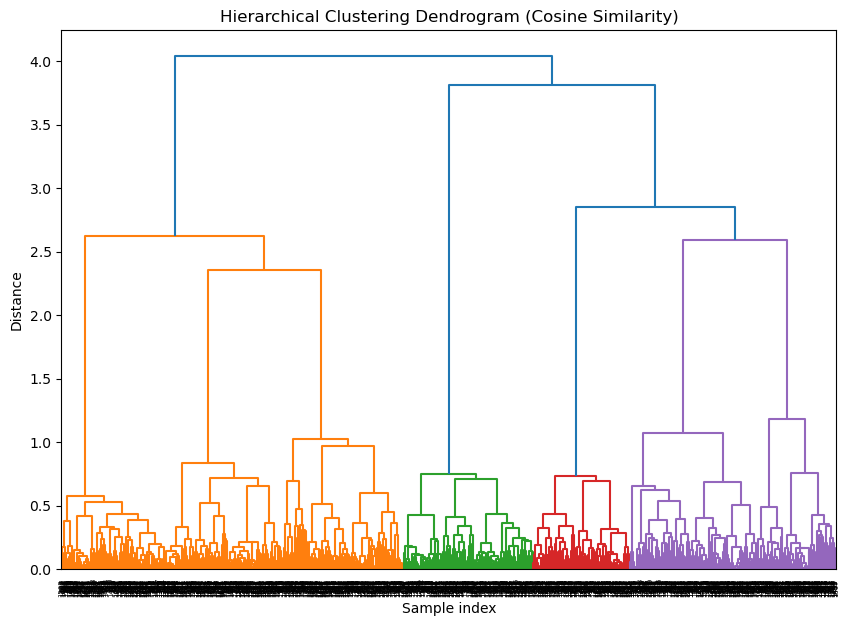

In [27]:
import pandas as pd
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist
import matplotlib.pyplot as plt

# Calculate the cosine distance matrix
cosine_distances = pdist(pdf_cleaned['Embedding_list'].tolist(), metric='cosine')


# Perform hierarchical clustering using the cosine distance matrix
Z = linkage(cosine_distances, method='ward')

# Plot the dendrogram
plt.figure(figsize=(10, 7))
dendrogram(Z)
plt.title('Hierarchical Clustering Dendrogram (Cosine Similarity)')
plt.xlabel('Sample index')
plt.ylabel('Distance')
plt.show()

Let's pick 100 clusters

In [28]:
clusters_count = 100

StatementMeta(, 74b7028d-71e0-4c82-9b60-67d2c99a5b3c, 32, Finished, Available, Finished)

Print which questions ended up in each cluster, from 1st to 100th...

In [29]:
from scipy.cluster.hierarchy import fcluster

# Function to display clusters and their members
def display_clusters(Z, pdf_cleaned, num_clusters=200):
    # Create clusters from the linkage matrix
    clusters = fcluster(Z, num_clusters, criterion='maxclust')
    
    # Add cluster labels to the DataFrame
    pdf_cleaned['Cluster'] = clusters
    
    # Display clusters and their members
    for cluster in set(clusters):
        print(f"\nCluster {cluster}:")
        cluster_data = pdf_cleaned[pdf_cleaned['Cluster'] == cluster]
        for index, row in cluster_data.iterrows():
            print(f"\n\nThread id:  {row['Id']}, Question: {row['question_refined']}, Theme:  {row['Theme']}, Original post: {row['parent_post_text']}")

# Display clusters and their members
display_clusters(Z, pdf_cleaned, num_clusters=clusters_count)

StatementMeta(, 74b7028d-71e0-4c82-9b60-67d2c99a5b3c, 33, Finished, Available, Finished)


Cluster 1:


Thread id:  messages_Leadership_20250320_142054_0a875d3e, Question: What are the impacts of different leadership styles on team performance and employee morale?, Theme:  Leadership, Original post: Hi team, I’d like to discuss the impacts of different leadership styles—like transformational vs. servant leadership—on team performance and employee morale. Thoughts?


Thread id:  messages_Leadership_20250320_104650_f3f26191, Question: How can a leader determine which style is most effective in a given situation?, Theme:  Leadership, Original post: How do different leadership styles—such as transformational, servant, or autocratic leadership—impact team dynamics and performance, and how can a leader determine which style is most effective in a given situation?


Thread id:  messages_Leadership_20250320_081228_ca6a5f3e, Question: What is your perspective on leadership styles and their impact on performance and morale?, Theme:  Leadership, Original post: Hi team, let's discuss l

Now display the contents of each cluster in descending order by size (to help us find most frequently asked questions!)

In [30]:
# Count the number of members in each cluster
cluster_counts = pdf_cleaned['Cluster'].value_counts()

# Print the number of elements in each cluster and examples of questions inside the clusters
print("\nNumber of elements in each cluster and examples of questions inside the clusters:")
for cluster, count in cluster_counts.items():
    print(f"\n\nCluster {cluster}: {count} elements")
    cluster_data = pdf_cleaned[pdf_cleaned['Cluster'] == cluster]
    for index, row in cluster_data.iterrows():  # Displaying first 3 examples from each cluster
        print(f"\n\nThread id:  {row['Id']}, Question: {row['question_refined']}, Theme:  {row['Theme']}, Original post: {row['parent_post_text']}")


StatementMeta(, 74b7028d-71e0-4c82-9b60-67d2c99a5b3c, 34, Finished, Available, Finished)


Number of elements in each cluster and examples of questions inside the clusters:


Cluster 20: 72 elements


Thread id:  messages_Education_20250320_141835_0f04b6db, Question: How could we redesign education systems to align with the challenges of a rapidly changing world?, Theme:  Education, Original post: Hey team, I've been thinking about how we could redesign education systems to align with the challenges of a rapidly changing world. Thoughts?


Thread id:  messages_Education_20250320_073704_5f1255a5, Question: How can education systems better prepare students for the demands of the 21st century?, Theme:  Education, Original post: Team, let's brainstorm ideas on how education systems can better prepare students for the demands of the 21st century while enhancing critical thinking, creativity, and emotional intelligence. Thoughts? <at id="0">Alex Roberts</at> <at id="1">Jordan Mills</at>


Thread id:  messages_Education_20250320_102648_6d5d8901, Question: How can education systems

# Summarize the contents of each cluster - compress groups of questions with the help of GPT

In [31]:
def find_common_theme(text, verbose=1, questions_only = 1):
    # Craft the prompt
    if questions_only:
        prompt = f"Please find common thene in the given questions and context:\
                \n\n{text}\n\n\
                Based on that, formulate one aggregated most popular question (ideally) or few questions based on trends in the provided data. Answer Question(s): <> "
    else: 
        prompt = f"Please find common thene in the given questions and context:\
                \n\n{text}\n\n\
                Formulate common theme as a topic,  a set of keywords and  one aggregated most popular question (ideally) or few questions based on trends in the provided data. Answer as Topic: <>,  Keywords: <>, Question(s): <> "
        

    messages = [
        {
            "role": "system",
            "content": """You are a helpful  assistant who will be provided text information to generate FAQ \
                """
        }
    ]

    messages.append(
        {
            "role": "user", 
            "content": "question:" + prompt,
        },
    )

    attempts = 0
    result = ''
    
    #print(f"start to work on input: {text}")
    while attempts < 10 and result == '':
        try:
            attempts+=1 

            response = openai.ChatCompletion.create(
                #deployment_id='gpt-35-turbo-0125', # see the note in the cell below for an alternative deployment_id.
                deployment_id="gpt-4-32k",
                messages= messages,
                temperature=0,
            ) 

            result = response.choices[0].message.content
            #print(result)
        except Exception as e:
            print(e)
            print(f"sleeping, attempt {attempts}")
            import time
            time.sleep(attempts*19)

    return result if result !='' else 'Failure' 


StatementMeta(, 74b7028d-71e0-4c82-9b60-67d2c99a5b3c, 35, Finished, Available, Finished)

Apply the function only to clusters that have 5 or more questions

In [32]:
# Count the number of members in each cluster
cluster_counts = pdf_cleaned['Cluster'].value_counts()

# Filter clusters with more than 5 entries and sort in descending order
filtered_clusters = cluster_counts[cluster_counts > 5].sort_values(ascending=False)

themes = []
# Print the number of elements in each cluster and concatenated questions
#print("\nNumber of elements in each cluster and examples of questions inside the clusters (more than 5 entries):")
for cluster, count in filtered_clusters.items():
    #print(f"\n\nCluster {cluster}: {count} elements")
    cluster_data = pdf_cleaned[pdf_cleaned['Cluster'] == cluster]
    questions = []
    parent_posts = []
    for index, row in cluster_data.iterrows():
        questions.append(f"Question: {row['question_refined']}")
        # print(f"\n\nThread id:  {row['Id']}, Question: {row['question_refined']}, Theme:  {row['Theme']}, Original post: {row['parent_post_text']}")
        parent_posts.append(f"Post: {row['parent_post_text']}")
      
    result = "  Questions: " + " | ".join(questions)
    theme = find_common_theme(result)
    parent_posts = "  Parent posts: " + " | ".join(parent_posts)    
    themes.append((theme, count))
    #print(f"\n{theme}; \n\n {parent_posts}")

print("~~~FAQ~~~~")
for theme, num in themes:
    print(theme, f" (asked {num} times)\n =================== \n")

StatementMeta(, 74b7028d-71e0-4c82-9b60-67d2c99a5b3c, 36, Finished, Available, Finished)

Rate limit is exceeded. Try again in 10 seconds.
sleeping, attempt 1
Rate limit is exceeded. Try again in 8 seconds.
sleeping, attempt 1
Rate limit is exceeded. Try again in 14 seconds.
sleeping, attempt 1
Rate limit is exceeded. Try again in 12 seconds.
sleeping, attempt 1
~~~FAQ~~~~
Question: How can education systems adapt and evolve to better prepare students for the rapidly changing demands of the 21st-century workforce, technological advancements, and global challenges?  (asked 72 times)

Question: What are the essential safety precautions, preparations, and gear needed for a successful and enjoyable hiking trip, especially in remote, high-altitude, or challenging terrains?  (asked 55 times)

Question: What are the essential items to pack for a safe, comfortable, and enjoyable day hike or multi-day backpacking trip, considering factors like weather changes, terrain variation, and trail familiarity?  (asked 49 times)

Question: How do intermolecular forces, including hydrogen bond

## Augment with answers - homework exercise 😊🙌